In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


### 1. 데이터 로드 및 구조 확인

In [ ]:
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### 2. 기술통계량


In [ ]:
stats = iris.groupby('species')['petal_length'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,50.0,1.462,0.173664,1.0,1.4,1.50,1.575,1.9
versicolor,50.0,4.260,0.469911,3.0,4.0,4.35,4.600,5.1
virginica,50.0,5.552,0.551895,4.5,5.1,5.55,5.875,6.9


In [ ]:
iris['species'].value_counts()  # 종(그룹) 별 데이터 개수

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

### 3. 시각화

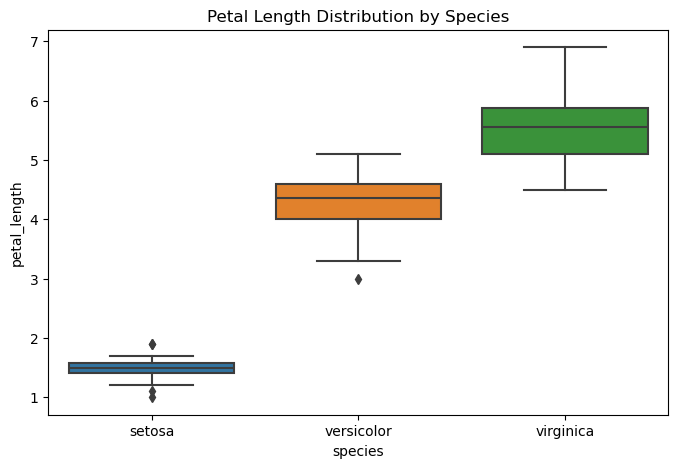

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='species', y='petal_length', data=iris)
plt.title('Petal Length Distribution by Species')
plt.show()

### 4. 정규성 검정 (Shapiro-Wilk) 
- 품종 별 정규분포 따르는지

In [ ]:
for sp in iris['species'].unique():
    stat, p_value= shapiro(
        iris[iris['species'] == sp]['petal_length']
    )
    print(f"{sp}: p-value = {p_value:.4f}")

setosa: p-value = 0.0548
versicolor: p-value = 0.1585
virginica: p-value = 0.1098


### 5. 등분산성 검정 (Levene) 
- 종들의 분산이 같은지

In [ ]:
setosa = iris[iris['species'] == 'setosa']['petal_length']
versicolor = iris[iris['species'] == 'versicolor']['petal_length']
virginica = iris[iris['species'] == 'virginica']['petal_length']

stat, p_value = levene(setosa, versicolor, virginica)
print(f"Levene test p-value: {p_value:.4f}")

Levene test p-value: 0.0000


### 6. ANOVA 가설 수립
- 귀무가설(H0): 세 species 간 petal length 평균은 모두 같다
- 대립가설(H1): 적어도 한 species의 petal length 평균은 다르다

### 7. One-way ANOVA

In [ ]:
f_stat, p = f_oneway(setosa, versicolor, virginica)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p:.4e}")

F-statistic: 1180.1612
p-value: 2.8568e-91


### 8. 사후검정 (Tukey HSD)

In [ ]:
tukey = pairwise_tukeyhsd(
    endog=iris['petal_length'],
    groups=iris['species'],
    alpha=0.05
)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


### 9. 결과 요약
petal length는 setosa가 가장 짧고, virginica가 가장 길며, versicolor는 중간 수준이라고 결론지을 수 있다.

### 10. 회귀 분석

In [ ]:
# 1) 데이터 분리
X = iris[['sepal_length', 'sepal_width', 'petal_width']]
y = iris['petal_length']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 3) 예측 및 평가
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


# 4) 회귀계수 확인
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

coef_df


MSE: 0.1300
R²: 0.9603


,Feature,Coefficient
0,sepal_length,0.722815
1,sepal_width,-0.635816
2,petal_width,1.467524
